In [1]:
import xml.etree.ElementTree as ET
import os
import numpy as np
import math
import json
import matplotlib.pyplot as plt

In [2]:
%config Completer.use_jedi = False

In [3]:
pathBatch = "../real/real/real/ALASKA_photo"
markupPath = os.path.join(pathBatch, "Markup")
imagePath = os.path.join(pathBatch, "Image")

In [4]:
import numpy as np
import cv2
import math
from math import exp


def pointAngle(Apoint, Bpoint):
    angle = (Bpoint[1] - Apoint[1]) / ((Bpoint[0] - Apoint[0]) + 10e-8)
    return angle

def pointDistance(Apoint, Bpoint):
    return math.sqrt((Bpoint[1] - Apoint[1])**2 + (Bpoint[0] - Apoint[0])**2)

def lineBiasAndK(Apoint, Bpoint):
    K = pointAngle(Apoint, Bpoint)
    B = Apoint[1] - K*Apoint[0]
    return K, B

def getX(K, B, Ypoint):
    return int((Ypoint-B)/K)

def sidePoint(Apoint, Bpoint, h, w, placehold):

    K, B = lineBiasAndK(Apoint, Bpoint)
    angle = abs(math.atan(pointAngle(Apoint, Bpoint)))
    distance = pointDistance(Apoint, Bpoint)

    halfIncreaseDistance = 0.5 * distance

    XaxisIncreaseDistance = abs(math.cos(angle) * halfIncreaseDistance)
    YaxisIncreaseDistance = abs(math.sin(angle) * halfIncreaseDistance)

    if placehold == 'leftTop':
        x1 = max(0, Apoint[0] - XaxisIncreaseDistance)
        y1 = max(0, Apoint[1] - YaxisIncreaseDistance)
    elif placehold == 'rightTop':
        x1 = min(w, Bpoint[0] + XaxisIncreaseDistance)
        y1 = max(0, Bpoint[1] - YaxisIncreaseDistance)
    elif placehold == 'rightBottom':
        x1 = min(w, Bpoint[0] + XaxisIncreaseDistance)
        y1 = min(h, Bpoint[1] + YaxisIncreaseDistance)
    elif placehold == 'leftBottom':
        x1 = max(0, Apoint[0] - XaxisIncreaseDistance)
        y1 = min(h, Apoint[1] + YaxisIncreaseDistance)

    return int(x1), int(y1)

# 将box扩大1.5倍
def enlargebox(box, h, w):
   # print(box)
    # box = [Apoint, Bpoint, Cpoint, Dpoint]
    Apoint, Bpoint, Cpoint, Dpoint = box
    K1, B1 = lineBiasAndK(box[0], box[2])
    K2, B2 = lineBiasAndK(box[3], box[1])
    X = (B2 - B1)/(K1 - K2)
    Y = K1 * X + B1
    center = [X, Y]

    x1, y1 = sidePoint(Apoint, center, h, w, 'leftTop')
    x2, y2 = sidePoint(center, Bpoint, h, w, 'rightTop')
    x3, y3 = sidePoint(center, Cpoint, h, w, 'rightBottom')
    x4, y4 = sidePoint(Dpoint, center, h, w, 'leftBottom')
    newcharbox = np.array([[x1, y1], [x2, y2], [x3, y3], [x4, y4]])
    return newcharbox

# coding=utf-8
from math import exp
import numpy as np
import cv2
import os
import math
#from gaussianMap import imgproc
#from data.boxEnlarge import enlargebox


class GaussianTransformer(object):

    def __init__(self, imgSize=200, enlargeSize=1.50):
        self.imgSize = imgSize
        isotropicGrayscaleImage, isotropicGrayscaleImageColor = self.gen_gaussian_heatmap()
        self.standardGaussianHeat = isotropicGrayscaleImage
        self.enlargeSize = enlargeSize
        # color_gaussian = cv2.applyColorMap(self.standardGaussianHeat, cv2.COLORMAP_JET)
        # cv2.imshow("test", color_gaussian)
        # cv2.waitKey(0)
        # self._test()

    def gen_gaussian_heatmap(self):
        circle_mask = self.gen_circle_mask()
        imgSize = self.imgSize
        isotropicGrayscaleImage = np.zeros((imgSize, imgSize), np.float32)

        # scaledGaussian = lambda x: exp(-((x ** 2)/(2 * (40 **2)))) * (1 / sqrt(2 * pi * (40 **2)))
        # scaledGaussian = lambda x: exp(-((x ** 2) / (2 * (40 ** 2))))

        # 生成高斯图
        for i in range(imgSize):
            for j in range(imgSize):
                isotropicGrayscaleImage[i, j] = 1 / 2 / np.pi / (40 ** 2) * np.exp(
                    -1 / 2 * ((i - imgSize / 2) ** 2 / (40 ** 2) + (j - imgSize / 2) ** 2 / (40 ** 2)))
        # 如果要可视化对比正方形和最大内切圆高斯图的区别，注释下面这行即可
        isotropicGrayscaleImage = isotropicGrayscaleImage * circle_mask
        isotropicGrayscaleImage = (isotropicGrayscaleImage / np.max(isotropicGrayscaleImage)).astype(np.float32)

        isotropicGrayscaleImage = (isotropicGrayscaleImage / np.max(isotropicGrayscaleImage) * 255).astype(np.uint8)
        isotropicGrayscaleImageColor = cv2.applyColorMap(isotropicGrayscaleImage, cv2.COLORMAP_JET)
        return isotropicGrayscaleImage, isotropicGrayscaleImageColor

    # 生成高斯图的mask，对于正方形的高斯图来说，只将最大内切圆作为字符的高斯图区域去学习
    # 在初版开源的高斯图生成中，是将正方形完整区域作为高斯图的
    # 新的方法可视化后与作者论文中展示的可视化效果是完全一致的
    def gen_circle_mask(self):
        imgSize = self.imgSize
        circle_img = np.zeros((imgSize, imgSize), np.float32)
        circle_mask = cv2.circle(circle_img, (imgSize//2, imgSize//2), imgSize//2, 1, -1)

        # circle_mask = cv2.circle(circle_img, (imgSize//2, imgSize//2), imgSize//2, 255, -1)
        # circle_mask = cv2.applyColorMap(circle_mask, cv2.COLORMAP_JET)
        # cv2.imshow("circle", circle_mask)
        # cv2.waitKey(0)
        return circle_mask

    # 将原始的box扩大1.5倍
    # 仅仅作用于正矩形，不规则四边形无效， 请参考data/boEnlarge文件
    def enlargeBox(self, box, imgh, imgw):
        boxw = box[1][0] - box[0][0]
        boxh = box[2][1] - box[1][1]

        if imgh <= boxh or imgw <= boxw:
            return box

        enlargew = boxw * 0.5
        enlargeh = boxh * 0.5

        # box扩大这部分为了清晰，code写的比较冗余
        # 左上角顶点扩充后坐标， 剩下点顺时针以此类推
        box[0][0], box[0][1] = max(0, box[0][0] - int(enlargew*0.5)), max(0, box[0][1] - int(enlargeh*0.5))
        box[1][0], box[1][1] = min(imgw, box[1][0] + int(enlargew*0.5)), max(0, box[1][1] - int(enlargeh*0.5))
        box[2][0], box[2][1] = min(imgw, box[2][0] + int(enlargew*0.5)), min(imgh, box[2][1] + int(enlargeh*0.5))
        box[3][0], box[3][1] = max(0, box[3][0] - int(enlargew*0.5)), min(imgh, box[3][1] + int(enlargeh*0.5))

        return box

    def four_point_transform(self, target_bbox, save_dir=None):
        '''
        :param target_bbox:目标bbox
        :param save_dir:如果不是None，则保存图片到save_dir中
        :return:
        '''
        width, height = np.max(target_bbox[:, 0]).astype(np.int32), np.max(target_bbox[:, 1]).astype(np.int32)
        right = self.standardGaussianHeat.shape[1] - 1
        bottom = self.standardGaussianHeat.shape[0] - 1
        ori = np.array([[0, 0], [right, 0],
                        [right, bottom],
                        [0, bottom]], dtype="float32")
        M = cv2.getPerspectiveTransform(ori, target_bbox)
        warped = cv2.warpPerspective(self.standardGaussianHeat.copy(), M, (int(width), int(height)))
        warped = np.array(warped, np.uint8)
        if save_dir:
            warped_color = cv2.applyColorMap(warped, cv2.COLORMAP_JET)
            cv2.imwrite(os.path.join(save_dir, 'warped.jpg'), warped_color)

        return warped, width, height

    def add_character(self, image, bbox, singal = None):
        # bbox = self.enlargeBox(bbox, image.shape[0], image.shape[1])
        bbxo_copy = bbox.copy()
        bbox = enlargebox(bbox, image.shape[0], image.shape[1])
        if singal == "affinity":
            bbox[0][0], bbox[1][0], bbox[2][0], bbox[3][0] = bbxo_copy[0][0], bbxo_copy[1][0], bbxo_copy[2][0], bbxo_copy[3][0]

        # bbox = np.array([[45, 135], [135, 135], [135, 295], [45, 295]], dtype=np.float32)

        if np.any(bbox < 0) or np.any(bbox[:, 0] > image.shape[1]) or np.any(bbox[:, 1] > image.shape[0]):
            return image
        ori_box = bbox
        top_left = np.array([np.min(bbox[:, 0]), np.min(bbox[:, 1])]).astype(np.int32)
        point = top_left
        bbox -= top_left[None, :]
        transformed, width, height = self.four_point_transform(bbox.astype(np.float32))
        # if width * height < 10:
        #     return image
        try:
            score_map = image[top_left[1]:top_left[1] + transformed.shape[0],
                        top_left[0]:top_left[0] + transformed.shape[1]]
            score_map = np.where(transformed > score_map, transformed, score_map)
            image[top_left[1]:top_left[1] + transformed.shape[0],
            top_left[0]:top_left[0] + transformed.shape[1]] = score_map
        except Exception as e:
            # print('tansformed shape:{}\n image top_left shape:{}\n top transformed shape:{}\n width and hright:{}\n ori box:{}\n top left:{}\n point:{}\n min width height:{}\n bbox:{}\n'
            #       .format(transformed.shape, image[top_left[1]:top_left[1],
            # top_left[0]:top_left[0]].shape, image[top_left[1]:top_left[1] + transformed.shape[0],
            # top_left[0]:top_left[0] + transformed.shape[1]].shape, (width, height), ori_box, top_left,point,
            #       np.array([np.min(ori_box[:, 0]), np.min(ori_box[:, 1])]).astype(np.int32),
            #       ori_box-np.array([np.min(ori_box[:, 0]), np.min(ori_box[:, 1])]).astype(np.int32)))
            print('second filter {} {} {}'.format(width,height,singal))
        return image

    def add_affinity(self, image, bbox_1, bbox_2):
        center_1, center_2 = np.mean(bbox_1, axis=0), np.mean(bbox_2, axis=0)
        tl = (bbox_1[0:2].sum(0) + center_1) / 3
        bl = (bbox_2[0:2].sum(0) + center_2) / 3
        tr = (bbox_2[2:4].sum(0) + center_2) / 3
        br = (bbox_1[2:4].sum(0) + center_1) / 3

        affinity = np.array([tl, bl, tr, br]).astype(np.float32)
        # tl = np.mean([bbox_1[0], bbox_1[1], center_1], axis=0)
        # bl = np.mean([bbox_1[2], bbox_1[3], center_1], axis=0)
        # tr = np.mean([bbox_2[0], bbox_2[1], center_2], axis=0)
        # br = np.mean([bbox_2[2], bbox_2[3], center_2], axis=0)
        #
        # affinity = np.array([tl, tr, br, bl])

        return self.add_character(image, affinity.copy(), singal='affinity'), np.expand_dims(affinity, axis=0)

    def generate_region(self, image_size, bboxes):
        height, width = image_size
        target = np.zeros([height, width], dtype=np.float32)
        for i in range(len(bboxes)):
            character_bbox = np.array(bboxes[i])
            for j in range(bboxes[i].shape[0]):
                target = self.add_character(target, character_bbox[j], singal='region')

        return target

    def saveGaussianHeat(self):
        images_folder = os.path.abspath(os.path.dirname(__file__)) + '/images'
        cv2.imwrite(os.path.join(images_folder, 'standard.jpg'), self.standardGaussianHeat)
        warped_color = cv2.applyColorMap(self.standardGaussianHeat, cv2.COLORMAP_JET)
        cv2.imwrite(os.path.join(images_folder, 'standard_color.jpg'), warped_color)
        standardGaussianHeat1 = self.standardGaussianHeat.copy()
        standardGaussianHeat1[standardGaussianHeat1 < (0.4 * 255)] = 255
        threshhold_guassian = cv2.applyColorMap(standardGaussianHeat1, cv2.COLORMAP_JET)
        cv2.imwrite(os.path.join(images_folder, 'threshhold_guassian.jpg'), threshhold_guassian)

    def generate_affinity(self, image_size, bboxes, words):
        height, width = image_size
        target = np.zeros([height, width], dtype=np.float32)
        affinities = []
        for i in range(len(words)):
            character_bbox = np.array(bboxes[i])
            total_letters = 0
            for char_num in range(character_bbox.shape[0] - 1):
                target, affinity = self.add_affinity(target, character_bbox[total_letters],
                                                     character_bbox[total_letters + 1])
                affinities.append(affinity)
                total_letters += 1
        if len(affinities) > 0:
            affinities = np.concatenate(affinities, axis=0)
        return target, affinities

In [5]:
def calcClockWise(v1,v2):
    return v1[0]*v2[1] - v1[1]*v2[0] >= 0

In [6]:
# import the necessary packages
from scipy.spatial import distance as dist
import numpy as np
import cv2
def order_points(pts):
    # sort the points based on their x-coordinates
    xSorted = pts[np.argsort(pts[:, 0]), :]
    # grab the left-most and right-most points from the sorted
    # x-roodinate points
    leftMost = xSorted[:2, :]
    rightMost = xSorted[2:, :]
    # now, sort the left-most coordinates according to their
    # y-coordinates so we can grab the top-left and bottom-left
    # points, respectively
    leftMost = leftMost[np.argsort(leftMost[:, 1]), :]
    (tl, bl) = leftMost
    # now that we have the top-left coordinate, use it as an
    # anchor to calculate the Euclidean distance between the
    # top-left and right-most points; by the Pythagorean
    # theorem, the point with the largest distance will be
    # our bottom-right point
    D = dist.cdist(tl[np.newaxis], rightMost, "euclidean")[0]
    (br, tr) = rightMost[np.argsort(D)[::-1], :]
    # return the coordinates in top-left, top-right,
    # bottom-right, and bottom-left order
    return np.array([tl, tr, br, bl], dtype="float32")

In [7]:
def sortPoint(points):
#     print("!")
#     print(points)
    size = len(points[0])
    if (points[0][0] < points[1][0] or (points[0][0] == points[1][0] and points[0][1] > points[1][1])) \
        and (points[0][0] < points[2][0] or (points[0][0] == points[2][0] and points[0][1] > points[2][1])) \
        and (points[0][0] < points[3][0] or (points[0][0] == points[3][0] and points[0][1] > points[3][1])):
        leftTopIndex = 0
    elif (points[1][0] < points[0][0] or (points[1][0] == points[0][0] and points[1][1] > points[0][1])) \
        and (points[1][0] < points[2][0] or (points[1][0] == points[2][0] and points[1][1] > points[2][1])) \
        and (points[1][0] < points[3][0] or (points[1][0] == points[3][0] and points[1][1] > points[3][1])):
        leftTopIndex = 1
    elif (points[2][0] < points[1][0]  or (points[2][0] == points[1][0] and points[2][1] > points[1][1])) \
        and (points[2][0] < points[0][0] or (points[2][0] == points[0][0] and points[2][1] > points[0][1])) \
        and (points[2][0] < points[3][0] or (points[2][0] == points[3][0] and points[2][1] > points[3][1])):
        leftTopIndex = 2
    else:
        leftTopIndex = 3
#     print("left" + str(leftTopIndex))
    
    inds = [0,1,2,3]
    inds.remove(leftTopIndex)
    
    v1 = points[inds[0]] - points[leftTopIndex]
    v2 = points[inds[1]] - points[inds[0]]
    v3 = points[inds[2]] - points[inds[0]]
    if calcClockWise(v1, v2) != calcClockWise(v1,v3):
        nextNextIndex = inds[0]        
    else:
        v1 = points[inds[1]] - points[leftTopIndex]
        v2 = points[inds[2]] - points[inds[1]]
        v3 = points[inds[0]] - points[inds[1]]
        if calcClockWise(v1, v2) != calcClockWise(v1,v3):
            nextNextIndex = inds[1]
        else:
            v1 = points[inds[2]] - points[leftTopIndex]
            v2 = points[inds[1]] - points[inds[2]]
            v3 = points[inds[0]] - points[inds[2]]
            print(v1)
            print(v2)
            print(v3)
            print(calcClockWise(v1, v2))
            print(calcClockWise(v1,v3))
            assert(calcClockWise(v1, v2) != calcClockWise(v1,v3))
            nextNextIndex = inds[2]
#     print("diag" + str(nextNextIndex))
    v1 = points[nextNextIndex] - points[leftTopIndex]
    v2 = points[inds[0]] - points[nextNextIndex]
    v3 = points[inds[1]] - points[nextNextIndex]
    if not calcClockWise(v1, v2):
        nextClockWiseIndex = inds[0]
        lastIndex = inds[1]
    else:
        assert(not calcClockWise(v1, v3))
        nextClockWiseIndex = inds[1]
        lastIndex = inds[0]
        
#     print("cclockw" + str(nextClockWiseIndex))
    return np.array((points[leftTopIndex],points[nextClockWiseIndex],points[nextNextIndex],points[lastIndex]))

In [8]:
def check(points):
    return
#     assert ( (points[0][0] < points[1][0] or (points[0][0] == points[1][0] and points[0][1] > points[1][1])) \
#         and (points[0][0] < points[2][0] or (points[0][0] == points[2][0] and points[0][1] > points[2][1])) \
#         and (points[0][0] < points[3][0] or (points[0][0] == points[3][0] and points[0][1] > points[3][1])) )


In [9]:
def getCharactersRects(rotated, word, imageW):
    cumW = 0
    W1 =  rotated[0][0] - rotated[1][0]
    H1 =  rotated[0][1] - rotated[1][1]
    
    W2 =  0#rotated[0][0] - rotated[3][0]
    H2 =  rotated[0][1] - rotated[1][1]
    H3 = rotated[2][1] - rotated[3][1]
    W = np.sqrt(W1**2 + H1**2)
    H = -np.sqrt(W2**2 + H2**2)
    
    W2 =  rotated[0][0] - rotated[3][0]
    H2 =  rotated[0][1] - rotated[3][1]
    HH = np.sqrt(W2**2 + H2**2)
    if HH >= W and len(word) > 4:
        return None #вертикальный текст
    characersResultRects = []
    cumW = 0
    w = W  / len(word)
    check(rotated)
#     characersResultRects.append([(rotated[0][0], imageW -rotated[0][1]), \
#                                  (rotated[0][0]+W, imageW -(rotated[0][1]-H)),\
#                                  (rotated[0][0], imageW -rotated[0][1]), (rotated[0][0]+W, imageW -(rotated[0][1]-H))])
    
    for i in range(len(word)):
        cumW += w
        characersResultRects.append(np.array([
            (rotated[0][0] + (cumW - w), imageW - (rotated[3][1] + (cumW - w)/ W * H)), \
            (rotated[0][0] + (cumW - w), imageW - (rotated[1][1] + (cumW)/ W * H)), \
            (rotated[0][0] + cumW, imageW - (rotated[1][1] + (cumW)/ W* H)),\
            (rotated[0][0] + cumW, imageW - (rotated[3][1] + (cumW-w) / W * H))\
        ]))
        characersResultRects[-1] = order_points(characersResultRects[-1]).tolist()
    return characersResultRects

In [27]:
def getAnnotation(root, W):
    annotation = dict()
    annotation["wordRects"] = []
    annotation["words"] = []
    annotation["wordsCharactersRects"] = []

    for child in root[0][0]:
#         if child[0].text != "Eyes":
#             continue
#         print("__")
        if child[0].text is None:
            continue
        att = child.attrib
        rect = [(att["x0"], W - int(att["y0"])), (att["x1"], W -int(att["y1"])), \
                (att["x2"], W - int(att["y2"])), (att["x3"], W -int(att["y3"]))]
        rect = np.array(rect, dtype=np.int)
        rect = order_points(rect)#sortPoint(rect)
#         print(rect)
#         print("*******************")
        text = child[0].text
        charRects = getCharactersRects(rect, text, W)
        if charRects is None:
            continue
        annotation["wordRects"].append([(rect[0][0], W - rect[0][1]), (rect[1][0], W - rect[1][1]), \
                                        (rect[2][0], W - rect[2][1]), (rect[3][0], W - rect[3][1])])
        annotation["wordRects"][-1] = np.array(annotation["wordRects"][-1]).tolist()
        
        annotation["words"].append(text)
        annotation["wordsCharactersRects"].append(charRects)
#         print(text)
        
            
    return annotation

In [28]:
from PIL import Image, ImageFont, ImageDraw
def getAnnotationImage(image, annotation):
    img = image.copy()
    d = ImageDraw.Draw(img)
    ind = 0
    d.line((0,0,100,100), fill=(255,255,255), width=20)
    for rotated, characters, text in zip(annotation["wordRects"], annotation["wordsCharactersRects"], annotation["words"]):
        d = ImageDraw.Draw(img)
        ind = ind + 1
#         print(text)
#         print(rotated)
#         d.line((rotated[0][0], rotated[0][1], rotated[1][0], rotated[1][1]), fill=(0,0,0), width=2)
#         d.line((rotated[1][0], rotated[1][1], rotated[2][0], rotated[2][1]), fill=(0,0,255), width=5)
#         d.line((rotated[2][0], rotated[2][1], rotated[3][0], rotated[3][1]), fill=(0,255,0), width=10)
#         d.line((rotated[3][0], rotated[3][1], rotated[0][0], rotated[0][1]), fill=(255,0,0), width=20)
        if characters is not None:
            for c in characters:

                c = np.array(c, dtype=np.int)
                #print(c)
                d.line((c[0][0], c[0][1], c[1][0], c[1][1]), fill=(0,0,255), width=2)
                d.line((c[1][0], c[1][1], c[2][0], c[2][1]), fill=(255,0,255), width=2)
                d.line((c[2][0], c[2][1], c[3][0], c[3][1]), fill=(255,0,255), width=2)
                d.line((c[3][0], c[3][1], c[0][0], c[0][1]), fill=(255,0,255), width=2)
    return img

In [29]:
pathToOutDir = R"D:\Data\Diploma\real\dataset//"
pathToGenerated = pathToOutDir + "generated"
pathToGT = pathToOutDir + "gt"

In [30]:

markupPath = os.path.join(pathBatch, "Markup")
imagePath = os.path.join(pathBatch, "Image")

In [33]:
from tqdm import tqdm_notebook as tn

In [34]:
os.makedirs(pathToGenerated, exist_ok=True)
os.makedirs(pathToGT, exist_ok=True)
dataList = []
pathToData = R"D:\Data\Diploma\real\real\real\Train_V2\\"
for batch in tn(os.listdir(pathToData)):
    pathBatch = os.path.join(pathToData, batch)
    for file in tn(os.listdir(markupPath)):
    #     if os.path.splitext(file)[0] != "0000018":
    #         continue
        filePath = os.path.join(markupPath, file)
        tree = ET.parse(filePath)
        root = tree.getroot()
        image = Image.open(os.path.join(imagePath, os.path.splitext(file)[0] + ".tif"))
        annotation = getAnnotation(root, image.size[0])

        rects = [np.array(wordCharRects, dtype=np.int)[np.newaxis, :, :,:] for wordCharRects in annotation["wordsCharactersRects"]]
        rects = np.hstack(rects,)
    #    # print(rects.shape)
        gen = GaussianTransformer()
        characterMap = gen.generate_region((image.size[1],image.size[0]), rects)
        #getAnnotationImage(image, annotation).show()

        gray = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (7, 7), 0)
        (T, threshInv) = cv2.threshold(blurred, 0, 255, cv2.THRESH_OTSU)

        distortedImage = image
        textImage = threshInv
        name =  batch + file
        name = name.encode("ascii", "ignore").decode()
        distoredImageName = "/"+ name +".png"
        gtName = "/"+ name + ".png"
        charMapName = "/"+ name + "CharMap.png"
        distortedImage.save(pathToGenerated + distoredImageName)
        cv2.imwrite(pathToGT + gtName, textImage)
        cv2.imwrite(pathToGT + charMapName, characterMap)

        with open(pathToGT + "/"+ name+ ".json", mode="w") as f:
            json.dump(annotation, f)
            metadata = dict()
            metadata["distortedImage"] = "generated" + distoredImageName
            metadata["gtImage"] = "gt" + gtName
            metadata["characterMap"] = "gt" + charMapName
            metadata["annotation"] = "gt/" + name +".json"
            dataList.append(metadata)
            print(pathToGT + "/"+ name + "CharMap.png")
            assert(os.path.exists(pathToGT + "/"+ name + "CharMap.png"))
        
with open(pathToOutDir + "dataList.txt", mode="w",) as f:
    json.dump(dataList, f)

<ipython-input-34-a30de813f2d4>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tn(os.listdir(pathToData)):


<ipython-input-34-a30de813f2d4>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for file in tn(os.listdir(markupPath)):


<ipython-input-27-999652d21168>:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  rect = np.array(rect, dtype=np.int)


D:\Data\Diploma\real\dataset//gt/ALASKA_photo0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/ALASKA_photo0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/ALASKA_photo0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/ALASKA_photo0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/ALASKA_photo0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/ALASKA_photo0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/ALASKA_photo0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/ALASKA_photo0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/ALASKA_photo0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/ALASKA_photo0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/ALASKA_scan0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/ALASKA_scan0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/ALASKA_scan0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/ALASKA_scan0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/ALASKA_scan0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/ALASKA_scan0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/ALASKA_scan0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/ALASKA_scan0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/ALASKA_scan0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/ALASKA_scan0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/American.ID_photo0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/American.ID_photo0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/American.ID_photo0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/American.ID_photo0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/American.ID_photo0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/American.ID_photo0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/American.ID_photo0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/American.ID_photo0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/American.ID_photo0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/American.ID_photo0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/Arabic.Passport0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Arabic.Passport0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Arabic.Passport0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Arabic.Passport0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Arabic.Passport0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Arabic.Passport0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Arabic.Passport0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Arabic.Passport0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Arabic.Passport0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Arabic.Passport0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/ArgentinaID0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/ArgentinaID0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/ArgentinaID0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/ArgentinaID0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/ArgentinaID0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/ArgentinaID0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/ArgentinaID0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/ArgentinaID0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/ArgentinaID0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/ArgentinaID0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/Australia.DL_photo0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Australia.DL_photo0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Australia.DL_photo0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Australia.DL_photo0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Australia.DL_photo0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Australia.DL_photo0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Australia.DL_photo0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Australia.DL_photo0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Australia.DL_photo0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Australia.DL_photo0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/CALIFORNIA_photo0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/CALIFORNIA_photo0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/CALIFORNIA_photo0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/CALIFORNIA_photo0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/CALIFORNIA_photo0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/CALIFORNIA_photo0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/CALIFORNIA_photo0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/CALIFORNIA_photo0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/CALIFORNIA_photo0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/CALIFORNIA_photo0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/CALIFORNIA_scan0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/CALIFORNIA_scan0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/CALIFORNIA_scan0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/CALIFORNIA_scan0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/CALIFORNIA_scan0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/CALIFORNIA_scan0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/CALIFORNIA_scan0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/CALIFORNIA_scan0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/CALIFORNIA_scan0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/CALIFORNIA_scan0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/Chinese.ID_different0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Chinese.ID_different0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Chinese.ID_different0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Chinese.ID_different0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Chinese.ID_different0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Chinese.ID_different0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Chinese.ID_different0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Chinese.ID_different0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Chinese.ID_different0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Chinese.ID_different0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/CTC_10000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/CTC_10000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/CTC_10000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/CTC_10000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/CTC_10000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/CTC_10000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/CTC_10000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/CTC_10000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/CTC_10000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/CTC_10000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/CTC_20000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/CTC_20000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/CTC_20000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/CTC_20000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/CTC_20000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/CTC_20000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/CTC_20000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/CTC_20000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/CTC_20000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/CTC_20000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/DriverLicense_mix0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/DriverLicense_mix0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/DriverLicense_mix0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/DriverLicense_mix0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/DriverLicense_mix0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/DriverLicense_mix0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/DriverLicense_mix0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/DriverLicense_mix0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/DriverLicense_mix0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/DriverLicense_mix0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/EgyptianID0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/EgyptianID0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/EgyptianID0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/EgyptianID0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/EgyptianID0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/EgyptianID0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/EgyptianID0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/EgyptianID0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/EgyptianID0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/EgyptianID0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/EU_driver_license0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/EU_driver_license0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/EU_driver_license0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/EU_driver_license0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/EU_driver_license0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/EU_driver_license0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/EU_driver_license0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/EU_driver_license0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/EU_driver_license0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/EU_driver_license0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/FrenchID0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/FrenchID0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/FrenchID0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/FrenchID0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/FrenchID0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/FrenchID0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/FrenchID0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/FrenchID0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/FrenchID0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/FrenchID0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/German.ID0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/German.ID0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/German.ID0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/German.ID0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/German.ID0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/German.ID0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/German.ID0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/German.ID0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/German.ID0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/German.ID0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/IDForDA0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/IDForDA0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/IDForDA0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/IDForDA0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/IDForDA0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/IDForDA0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/IDForDA0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/IDForDA0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/IDForDA0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/IDForDA0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/ILLINOIS_photo0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/ILLINOIS_photo0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/ILLINOIS_photo0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/ILLINOIS_photo0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/ILLINOIS_photo0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/ILLINOIS_photo0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/ILLINOIS_photo0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/ILLINOIS_photo0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/ILLINOIS_photo0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/ILLINOIS_photo0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/ILLINOIS_scan0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/ILLINOIS_scan0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/ILLINOIS_scan0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/ILLINOIS_scan0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/ILLINOIS_scan0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/ILLINOIS_scan0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/ILLINOIS_scan0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/ILLINOIS_scan0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/ILLINOIS_scan0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/ILLINOIS_scan0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/INDIANA_photo0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/INDIANA_photo0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/INDIANA_photo0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/INDIANA_photo0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/INDIANA_photo0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/INDIANA_photo0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/INDIANA_photo0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/INDIANA_photo0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/INDIANA_photo0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/INDIANA_photo0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/INDIANA_scan0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/INDIANA_scan0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/INDIANA_scan0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/INDIANA_scan0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/INDIANA_scan0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/INDIANA_scan0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/INDIANA_scan0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/INDIANA_scan0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/INDIANA_scan0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/INDIANA_scan0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/IOWA_photo0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/IOWA_photo0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/IOWA_photo0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/IOWA_photo0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/IOWA_photo0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/IOWA_photo0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/IOWA_photo0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/IOWA_photo0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/IOWA_photo0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/IOWA_photo0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/IOWA_scan0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/IOWA_scan0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/IOWA_scan0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/IOWA_scan0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/IOWA_scan0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/IOWA_scan0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/IOWA_scan0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/IOWA_scan0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/IOWA_scan0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/IOWA_scan0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/KANSAS_photo0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/KANSAS_photo0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/KANSAS_photo0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/KANSAS_photo0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/KANSAS_photo0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/KANSAS_photo0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/KANSAS_photo0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/KANSAS_photo0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/KANSAS_photo0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/KANSAS_photo0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/KANSAS_scan0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/KANSAS_scan0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/KANSAS_scan0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/KANSAS_scan0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/KANSAS_scan0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/KANSAS_scan0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/KANSAS_scan0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/KANSAS_scan0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/KANSAS_scan0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/KANSAS_scan0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/KENTUCKY_photo0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/KENTUCKY_photo0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/KENTUCKY_photo0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/KENTUCKY_photo0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/KENTUCKY_photo0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/KENTUCKY_photo0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/KENTUCKY_photo0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/KENTUCKY_photo0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/KENTUCKY_photo0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/KENTUCKY_photo0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/KENTUCKY_scan0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/KENTUCKY_scan0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/KENTUCKY_scan0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/KENTUCKY_scan0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/KENTUCKY_scan0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/KENTUCKY_scan0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/KENTUCKY_scan0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/KENTUCKY_scan0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/KENTUCKY_scan0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/KENTUCKY_scan0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/Korean.ID0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Korean.ID0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Korean.ID0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Korean.ID0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Korean.ID0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Korean.ID0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Korean.ID0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Korean.ID0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Korean.ID0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Korean.ID0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/LebaneseID0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/LebaneseID0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/LebaneseID0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/LebaneseID0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/LebaneseID0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/LebaneseID0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/LebaneseID0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/LebaneseID0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/LebaneseID0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/LebaneseID0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/Lebanon.ID0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Lebanon.ID0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Lebanon.ID0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Lebanon.ID0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Lebanon.ID0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Lebanon.ID0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Lebanon.ID0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Lebanon.ID0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Lebanon.ID0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Lebanon.ID0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/LOUISIANA_photo0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/LOUISIANA_photo0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/LOUISIANA_photo0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/LOUISIANA_photo0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/LOUISIANA_photo0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/LOUISIANA_photo0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/LOUISIANA_photo0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/LOUISIANA_photo0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/LOUISIANA_photo0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/LOUISIANA_photo0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/LOUISIANA_scan0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/LOUISIANA_scan0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/LOUISIANA_scan0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/LOUISIANA_scan0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/LOUISIANA_scan0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/LOUISIANA_scan0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/LOUISIANA_scan0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/LOUISIANA_scan0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/LOUISIANA_scan0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/LOUISIANA_scan0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/MAINE_photo0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MAINE_photo0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MAINE_photo0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MAINE_photo0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MAINE_photo0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MAINE_photo0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MAINE_photo0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MAINE_photo0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MAINE_photo0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MAINE_photo0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/MAINE_scan0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MAINE_scan0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MAINE_scan0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MAINE_scan0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MAINE_scan0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MAINE_scan0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MAINE_scan0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MAINE_scan0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MAINE_scan0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MAINE_scan0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/MARYLAND_photo0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MARYLAND_photo0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MARYLAND_photo0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MARYLAND_photo0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MARYLAND_photo0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MARYLAND_photo0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MARYLAND_photo0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MARYLAND_photo0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MARYLAND_photo0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MARYLAND_photo0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/MARYLAND_scan0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MARYLAND_scan0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MARYLAND_scan0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MARYLAND_scan0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MARYLAND_scan0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MARYLAND_scan0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MARYLAND_scan0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MARYLAND_scan0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MARYLAND_scan0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MARYLAND_scan0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/MASSACHUSETTS_photo0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MASSACHUSETTS_photo0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MASSACHUSETTS_photo0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MASSACHUSETTS_photo0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MASSACHUSETTS_photo0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MASSACHUSETTS_photo0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MASSACHUSETTS_photo0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MASSACHUSETTS_photo0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MASSACHUSETTS_photo0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MASSACHUSETTS_photo0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/MASSACHUSETTS_scan0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MASSACHUSETTS_scan0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MASSACHUSETTS_scan0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MASSACHUSETTS_scan0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MASSACHUSETTS_scan0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MASSACHUSETTS_scan0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MASSACHUSETTS_scan0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MASSACHUSETTS_scan0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MASSACHUSETTS_scan0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MASSACHUSETTS_scan0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/Medical.ID0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Medical.ID0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Medical.ID0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Medical.ID0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Medical.ID0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Medical.ID0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Medical.ID0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Medical.ID0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Medical.ID0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Medical.ID0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/MICHIGAN_photo0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MICHIGAN_photo0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MICHIGAN_photo0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MICHIGAN_photo0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MICHIGAN_photo0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MICHIGAN_photo0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MICHIGAN_photo0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MICHIGAN_photo0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MICHIGAN_photo0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MICHIGAN_photo0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/MICHIGAN_scan0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MICHIGAN_scan0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MICHIGAN_scan0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MICHIGAN_scan0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MICHIGAN_scan0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MICHIGAN_scan0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MICHIGAN_scan0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MICHIGAN_scan0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MICHIGAN_scan0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MICHIGAN_scan0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/MINNESOTA_photo0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MINNESOTA_photo0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MINNESOTA_photo0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MINNESOTA_photo0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MINNESOTA_photo0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MINNESOTA_photo0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MINNESOTA_photo0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MINNESOTA_photo0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MINNESOTA_photo0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MINNESOTA_photo0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/MINNESOTA_scan0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MINNESOTA_scan0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MINNESOTA_scan0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MINNESOTA_scan0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MINNESOTA_scan0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MINNESOTA_scan0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MINNESOTA_scan0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MINNESOTA_scan0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MINNESOTA_scan0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MINNESOTA_scan0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/MISSISSIPPI_photo0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MISSISSIPPI_photo0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MISSISSIPPI_photo0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MISSISSIPPI_photo0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MISSISSIPPI_photo0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MISSISSIPPI_photo0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MISSISSIPPI_photo0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MISSISSIPPI_photo0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MISSISSIPPI_photo0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MISSISSIPPI_photo0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/MISSISSIPPI_scan0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MISSISSIPPI_scan0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MISSISSIPPI_scan0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MISSISSIPPI_scan0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MISSISSIPPI_scan0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MISSISSIPPI_scan0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MISSISSIPPI_scan0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MISSISSIPPI_scan0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MISSISSIPPI_scan0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MISSISSIPPI_scan0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/MISSOURI_photo0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MISSOURI_photo0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MISSOURI_photo0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MISSOURI_photo0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MISSOURI_photo0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MISSOURI_photo0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MISSOURI_photo0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MISSOURI_photo0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MISSOURI_photo0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MISSOURI_photo0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/MISSOURI_scan0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MISSOURI_scan0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MISSOURI_scan0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MISSOURI_scan0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MISSOURI_scan0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MISSOURI_scan0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MISSOURI_scan0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MISSOURI_scan0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MISSOURI_scan0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MISSOURI_scan0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/Mix doc_10000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Mix doc_10000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Mix doc_10000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Mix doc_10000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Mix doc_10000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Mix doc_10000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Mix doc_10000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Mix doc_10000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Mix doc_10000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Mix doc_10000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/MONTANA_photo0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MONTANA_photo0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MONTANA_photo0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MONTANA_photo0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MONTANA_photo0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MONTANA_photo0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MONTANA_photo0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MONTANA_photo0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MONTANA_photo0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MONTANA_photo0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/MONTANA_scan0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MONTANA_scan0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MONTANA_scan0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MONTANA_scan0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MONTANA_scan0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MONTANA_scan0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MONTANA_scan0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MONTANA_scan0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MONTANA_scan0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/MONTANA_scan0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/NEBRASKA_photo0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEBRASKA_photo0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEBRASKA_photo0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEBRASKA_photo0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEBRASKA_photo0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEBRASKA_photo0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEBRASKA_photo0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEBRASKA_photo0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEBRASKA_photo0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEBRASKA_photo0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/NEBRASKA_scan0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEBRASKA_scan0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEBRASKA_scan0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEBRASKA_scan0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEBRASKA_scan0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEBRASKA_scan0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEBRASKA_scan0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEBRASKA_scan0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEBRASKA_scan0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEBRASKA_scan0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/NEVADA_photo0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEVADA_photo0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEVADA_photo0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEVADA_photo0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEVADA_photo0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEVADA_photo0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEVADA_photo0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEVADA_photo0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEVADA_photo0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEVADA_photo0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/NEVADA_scan0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEVADA_scan0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEVADA_scan0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEVADA_scan0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEVADA_scan0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEVADA_scan0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEVADA_scan0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEVADA_scan0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEVADA_scan0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEVADA_scan0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/NEW HAMPSHIRE_photo0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEW HAMPSHIRE_photo0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEW HAMPSHIRE_photo0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEW HAMPSHIRE_photo0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEW HAMPSHIRE_photo0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEW HAMPSHIRE_photo0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEW HAMPSHIRE_photo0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEW HAMPSHIRE_photo0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEW HAMPSHIRE_photo0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEW HAMPSHIRE_photo0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/NEW HAMPSHIRE_scan0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEW HAMPSHIRE_scan0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEW HAMPSHIRE_scan0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEW HAMPSHIRE_scan0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEW HAMPSHIRE_scan0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEW HAMPSHIRE_scan0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEW HAMPSHIRE_scan0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEW HAMPSHIRE_scan0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEW HAMPSHIRE_scan0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEW HAMPSHIRE_scan0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/NEW JERSEY_photo0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEW JERSEY_photo0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEW JERSEY_photo0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEW JERSEY_photo0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEW JERSEY_photo0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEW JERSEY_photo0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEW JERSEY_photo0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEW JERSEY_photo0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEW JERSEY_photo0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEW JERSEY_photo0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/NEW JERSEY_scan0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEW JERSEY_scan0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEW JERSEY_scan0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEW JERSEY_scan0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEW JERSEY_scan0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEW JERSEY_scan0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEW JERSEY_scan0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEW JERSEY_scan0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEW JERSEY_scan0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEW JERSEY_scan0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/NEW MEXICO_photo0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEW MEXICO_photo0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEW MEXICO_photo0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEW MEXICO_photo0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEW MEXICO_photo0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEW MEXICO_photo0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEW MEXICO_photo0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEW MEXICO_photo0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEW MEXICO_photo0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEW MEXICO_photo0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/NEW MEXICO_scan0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEW MEXICO_scan0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEW MEXICO_scan0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEW MEXICO_scan0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEW MEXICO_scan0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEW MEXICO_scan0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEW MEXICO_scan0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEW MEXICO_scan0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEW MEXICO_scan0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEW MEXICO_scan0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/NEW YORK_photo0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEW YORK_photo0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEW YORK_photo0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEW YORK_photo0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEW YORK_photo0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEW YORK_photo0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEW YORK_photo0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEW YORK_photo0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEW YORK_photo0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEW YORK_photo0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/NEW YORK_scan0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEW YORK_scan0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEW YORK_scan0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEW YORK_scan0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEW YORK_scan0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEW YORK_scan0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEW YORK_scan0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEW YORK_scan0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEW YORK_scan0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NEW YORK_scan0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/NORTH CAROLINA_photo0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NORTH CAROLINA_photo0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NORTH CAROLINA_photo0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NORTH CAROLINA_photo0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NORTH CAROLINA_photo0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NORTH CAROLINA_photo0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NORTH CAROLINA_photo0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NORTH CAROLINA_photo0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NORTH CAROLINA_photo0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NORTH CAROLINA_photo0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/NORTH CAROLINA_scan0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NORTH CAROLINA_scan0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NORTH CAROLINA_scan0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NORTH CAROLINA_scan0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NORTH CAROLINA_scan0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NORTH CAROLINA_scan0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NORTH CAROLINA_scan0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NORTH CAROLINA_scan0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NORTH CAROLINA_scan0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NORTH CAROLINA_scan0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/NORTH DAKOTA_photo0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NORTH DAKOTA_photo0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NORTH DAKOTA_photo0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NORTH DAKOTA_photo0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NORTH DAKOTA_photo0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NORTH DAKOTA_photo0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NORTH DAKOTA_photo0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NORTH DAKOTA_photo0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NORTH DAKOTA_photo0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NORTH DAKOTA_photo0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/NORTH DAKOTA_scan0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NORTH DAKOTA_scan0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NORTH DAKOTA_scan0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NORTH DAKOTA_scan0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NORTH DAKOTA_scan0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NORTH DAKOTA_scan0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NORTH DAKOTA_scan0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NORTH DAKOTA_scan0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NORTH DAKOTA_scan0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/NORTH DAKOTA_scan0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/OHIO_photo0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/OHIO_photo0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/OHIO_photo0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/OHIO_photo0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/OHIO_photo0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/OHIO_photo0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/OHIO_photo0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/OHIO_photo0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/OHIO_photo0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/OHIO_photo0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/OHIO_scan0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/OHIO_scan0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/OHIO_scan0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/OHIO_scan0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/OHIO_scan0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/OHIO_scan0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/OHIO_scan0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/OHIO_scan0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/OHIO_scan0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/OHIO_scan0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/OKLAHOMA_photo0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/OKLAHOMA_photo0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/OKLAHOMA_photo0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/OKLAHOMA_photo0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/OKLAHOMA_photo0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/OKLAHOMA_photo0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/OKLAHOMA_photo0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/OKLAHOMA_photo0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/OKLAHOMA_photo0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/OKLAHOMA_photo0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/OKLAHOMA_scan0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/OKLAHOMA_scan0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/OKLAHOMA_scan0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/OKLAHOMA_scan0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/OKLAHOMA_scan0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/OKLAHOMA_scan0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/OKLAHOMA_scan0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/OKLAHOMA_scan0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/OKLAHOMA_scan0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/OKLAHOMA_scan0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/OREGON_photo0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/OREGON_photo0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/OREGON_photo0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/OREGON_photo0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/OREGON_photo0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/OREGON_photo0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/OREGON_photo0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/OREGON_photo0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/OREGON_photo0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/OREGON_photo0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/OREGON_scan0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/OREGON_scan0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/OREGON_scan0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/OREGON_scan0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/OREGON_scan0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/OREGON_scan0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/OREGON_scan0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/OREGON_scan0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/OREGON_scan0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/OREGON_scan0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/Passport.Russian_photo0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Passport.Russian_photo0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Passport.Russian_photo0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Passport.Russian_photo0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Passport.Russian_photo0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Passport.Russian_photo0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Passport.Russian_photo0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Passport.Russian_photo0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Passport.Russian_photo0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Passport.Russian_photo0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/PENSYLVANIA_photo0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/PENSYLVANIA_photo0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/PENSYLVANIA_photo0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/PENSYLVANIA_photo0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/PENSYLVANIA_photo0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/PENSYLVANIA_photo0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/PENSYLVANIA_photo0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/PENSYLVANIA_photo0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/PENSYLVANIA_photo0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/PENSYLVANIA_photo0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/PENSYLVANIA_scan0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/PENSYLVANIA_scan0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/PENSYLVANIA_scan0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/PENSYLVANIA_scan0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/PENSYLVANIA_scan0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/PENSYLVANIA_scan0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/PENSYLVANIA_scan0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/PENSYLVANIA_scan0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/PENSYLVANIA_scan0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/PENSYLVANIA_scan0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/QatarID0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/QatarID0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/QatarID0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/QatarID0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/QatarID0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/QatarID0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/QatarID0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/QatarID0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/QatarID0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/QatarID0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/RHODE ISLAND_photo0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/RHODE ISLAND_photo0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/RHODE ISLAND_photo0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/RHODE ISLAND_photo0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/RHODE ISLAND_photo0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/RHODE ISLAND_photo0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/RHODE ISLAND_photo0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/RHODE ISLAND_photo0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/RHODE ISLAND_photo0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/RHODE ISLAND_photo0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/RHODE ISLAND_scan0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/RHODE ISLAND_scan0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/RHODE ISLAND_scan0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/RHODE ISLAND_scan0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/RHODE ISLAND_scan0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/RHODE ISLAND_scan0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/RHODE ISLAND_scan0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/RHODE ISLAND_scan0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/RHODE ISLAND_scan0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/RHODE ISLAND_scan0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/RU-ID0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/RU-ID0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/RU-ID0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/RU-ID0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/RU-ID0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/RU-ID0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/RU-ID0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/RU-ID0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/RU-ID0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/RU-ID0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/Singapore.IC_photo0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Singapore.IC_photo0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Singapore.IC_photo0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Singapore.IC_photo0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Singapore.IC_photo0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Singapore.IC_photo0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Singapore.IC_photo0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Singapore.IC_photo0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Singapore.IC_photo0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Singapore.IC_photo0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/SOUTH CAROLINA_photo0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/SOUTH CAROLINA_photo0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/SOUTH CAROLINA_photo0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/SOUTH CAROLINA_photo0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/SOUTH CAROLINA_photo0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/SOUTH CAROLINA_photo0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/SOUTH CAROLINA_photo0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/SOUTH CAROLINA_photo0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/SOUTH CAROLINA_photo0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/SOUTH CAROLINA_photo0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/SOUTH CAROLINA_scan0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/SOUTH CAROLINA_scan0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/SOUTH CAROLINA_scan0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/SOUTH CAROLINA_scan0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/SOUTH CAROLINA_scan0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/SOUTH CAROLINA_scan0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/SOUTH CAROLINA_scan0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/SOUTH CAROLINA_scan0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/SOUTH CAROLINA_scan0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/SOUTH CAROLINA_scan0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/TENNESSEE_photo0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/TENNESSEE_photo0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/TENNESSEE_photo0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/TENNESSEE_photo0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/TENNESSEE_photo0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/TENNESSEE_photo0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/TENNESSEE_photo0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/TENNESSEE_photo0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/TENNESSEE_photo0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/TENNESSEE_photo0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/TENNESSEE_scan0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/TENNESSEE_scan0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/TENNESSEE_scan0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/TENNESSEE_scan0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/TENNESSEE_scan0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/TENNESSEE_scan0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/TENNESSEE_scan0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/TENNESSEE_scan0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/TENNESSEE_scan0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/TENNESSEE_scan0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/TEXAS_photo0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/TEXAS_photo0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/TEXAS_photo0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/TEXAS_photo0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/TEXAS_photo0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/TEXAS_photo0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/TEXAS_photo0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/TEXAS_photo0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/TEXAS_photo0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/TEXAS_photo0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/TEXAS_scan0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/TEXAS_scan0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/TEXAS_scan0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/TEXAS_scan0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/TEXAS_scan0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/TEXAS_scan0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/TEXAS_scan0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/TEXAS_scan0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/TEXAS_scan0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/TEXAS_scan0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/UAEID0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/UAEID0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/UAEID0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/UAEID0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/UAEID0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/UAEID0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/UAEID0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/UAEID0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/UAEID0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/UAEID0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/UTAH_photo0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/UTAH_photo0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/UTAH_photo0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/UTAH_photo0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/UTAH_photo0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/UTAH_photo0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/UTAH_photo0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/UTAH_photo0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/UTAH_photo0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/UTAH_photo0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/UTAH_scan0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/UTAH_scan0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/UTAH_scan0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/UTAH_scan0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/UTAH_scan0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/UTAH_scan0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/UTAH_scan0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/UTAH_scan0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/UTAH_scan0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/UTAH_scan0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/Vietnamese0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Vietnamese0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Vietnamese0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Vietnamese0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Vietnamese0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Vietnamese0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Vietnamese0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Vietnamese0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Vietnamese0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/Vietnamese0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/0000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/0000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/0000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/0000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/0000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/0000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/0000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/0000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/0000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/0000009.xmlCharMap.png



D:\Data\Diploma\real\dataset//gt/_20000000.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/_20000001.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/_20000002.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/_20000003.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/_20000004.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/_20000005.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/_20000006.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/_20000007.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/_20000008.xmlCharMap.png
D:\Data\Diploma\real\dataset//gt/_20000009.xmlCharMap.png




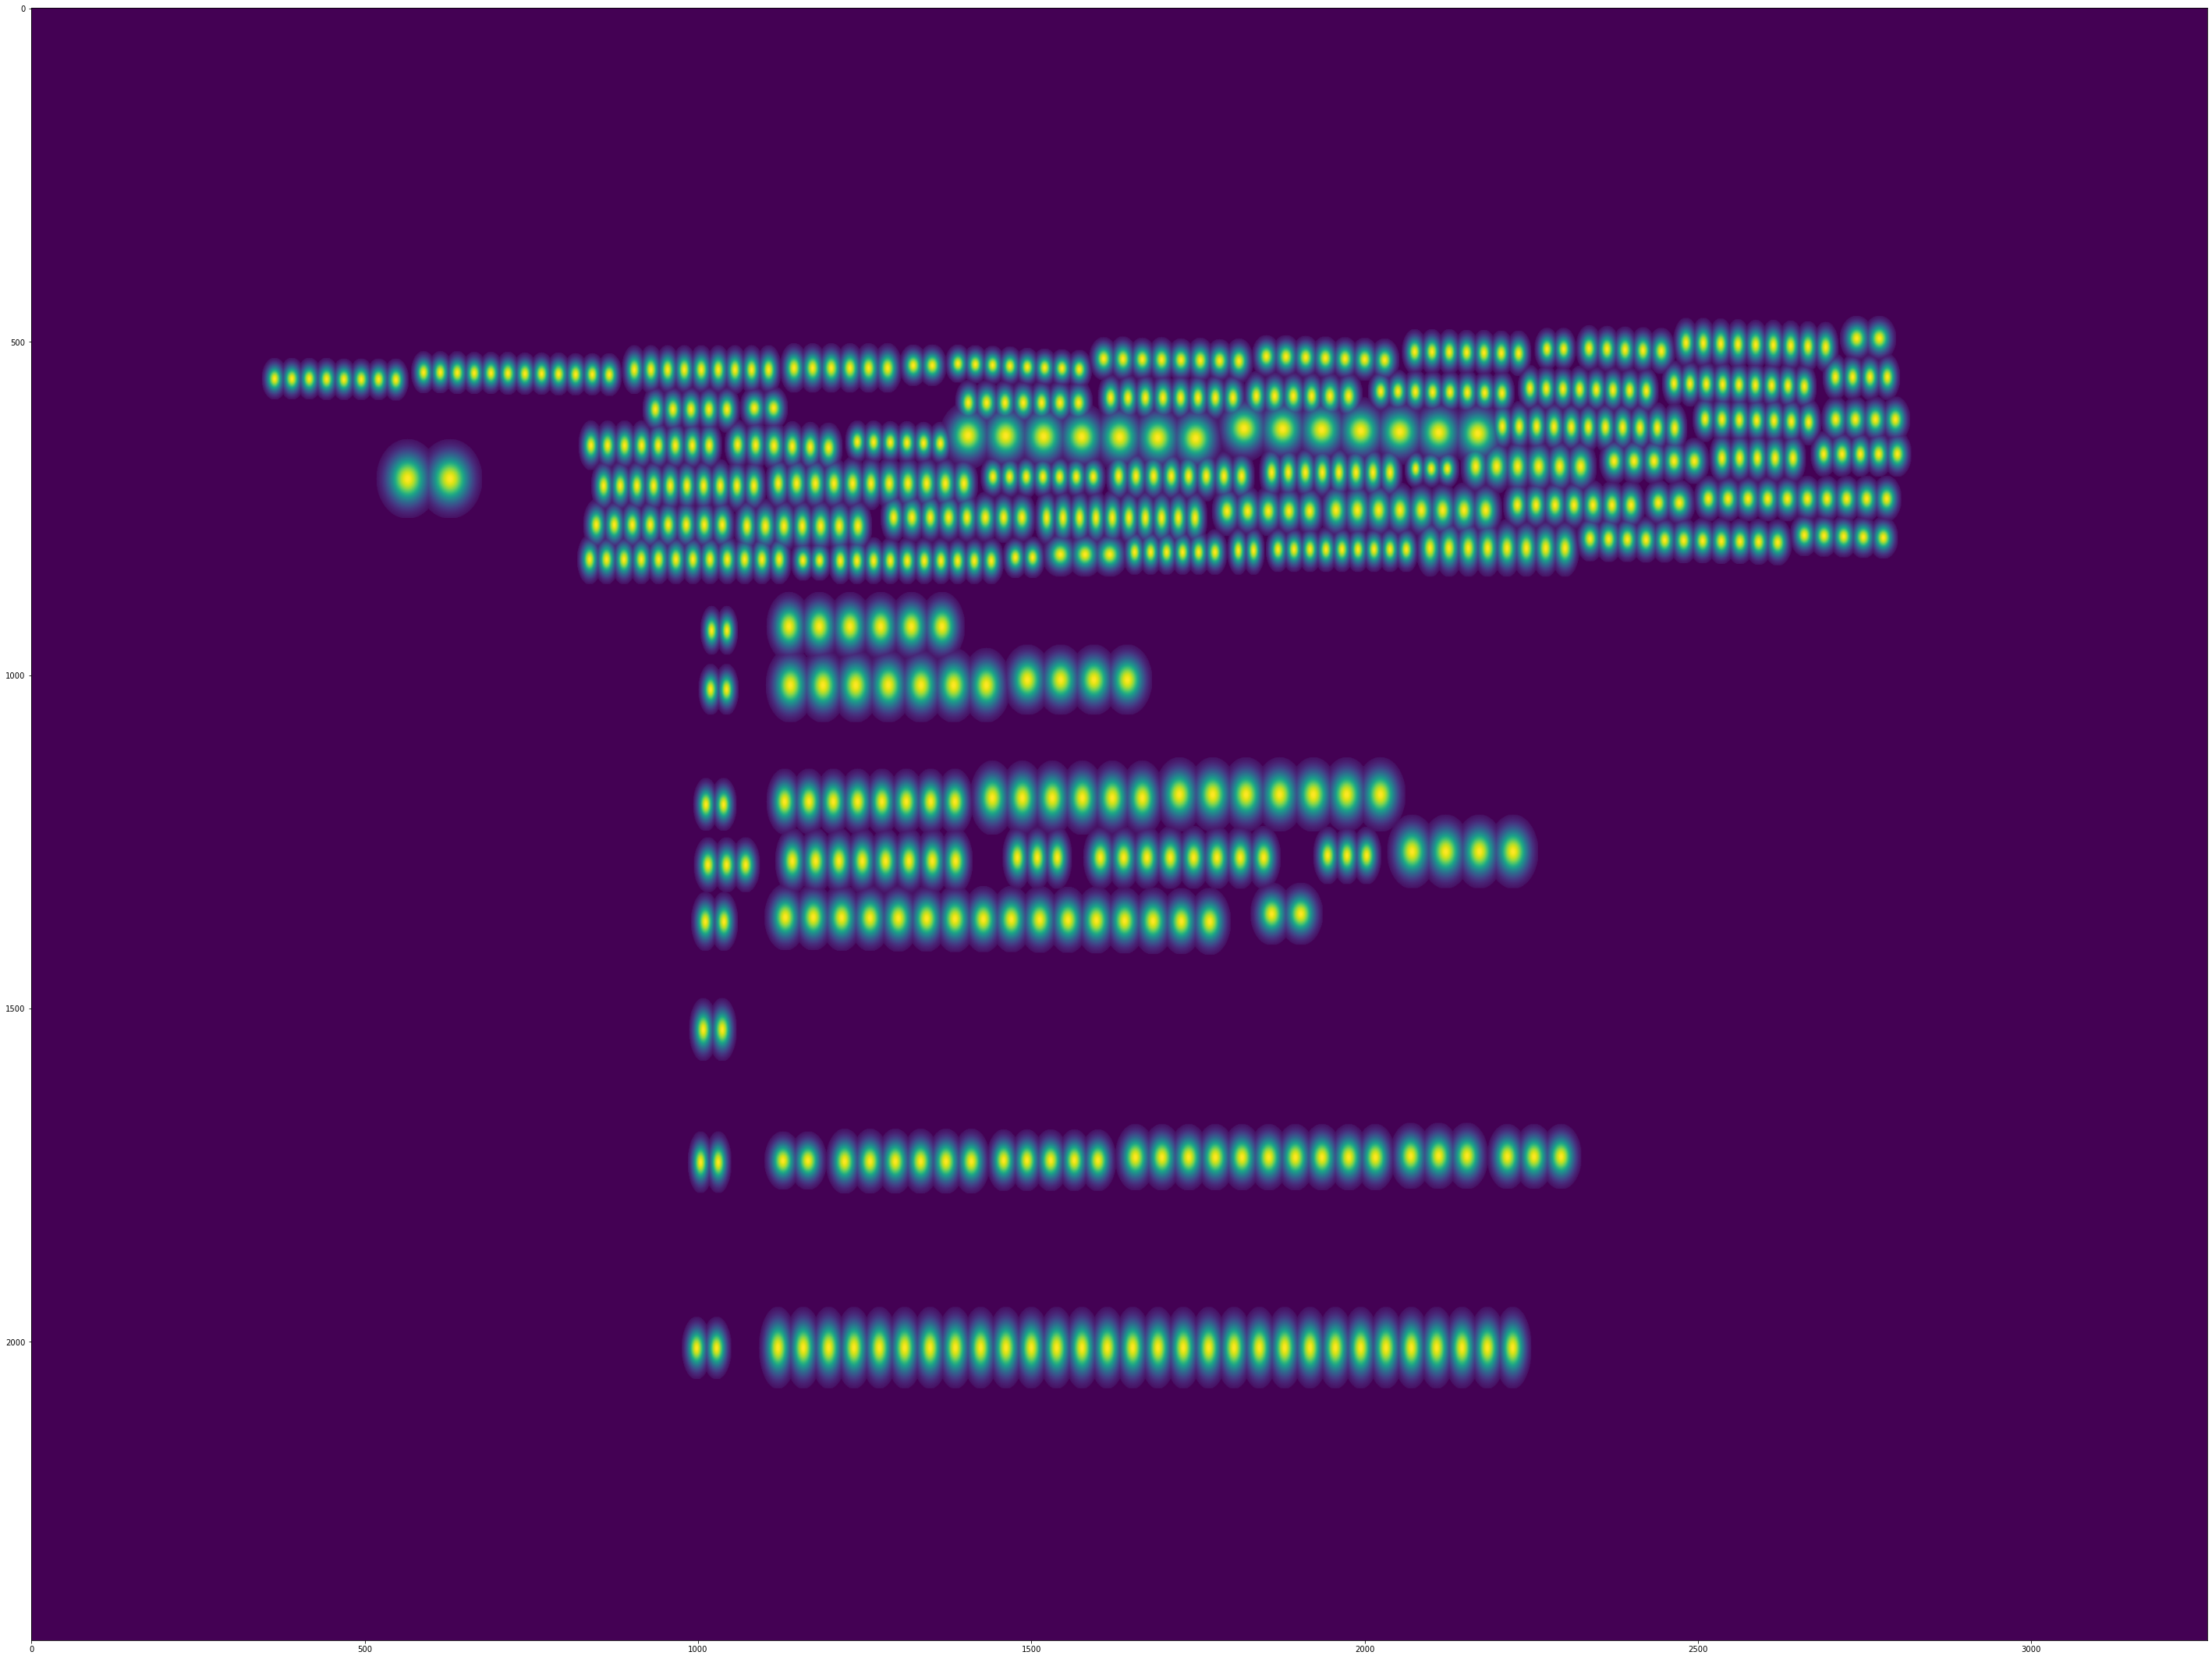

In [15]:
s = 50
plt.figure(figsize=(s,s))
plt.imshow(characterMap)